# Explore here

It's recommended to use this notebook for exploration purposes.

/tmp/ipykernel_1432/2268099171.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({


                 Date       Revenue
0       June 30, 2024  2.550000e+10
1      March 31, 2024  2.130000e+10
2   December 31, 2023  2.517000e+10
3  September 30, 2023  2.335000e+10
4       June 30, 2023  2.493000e+10
database already has data


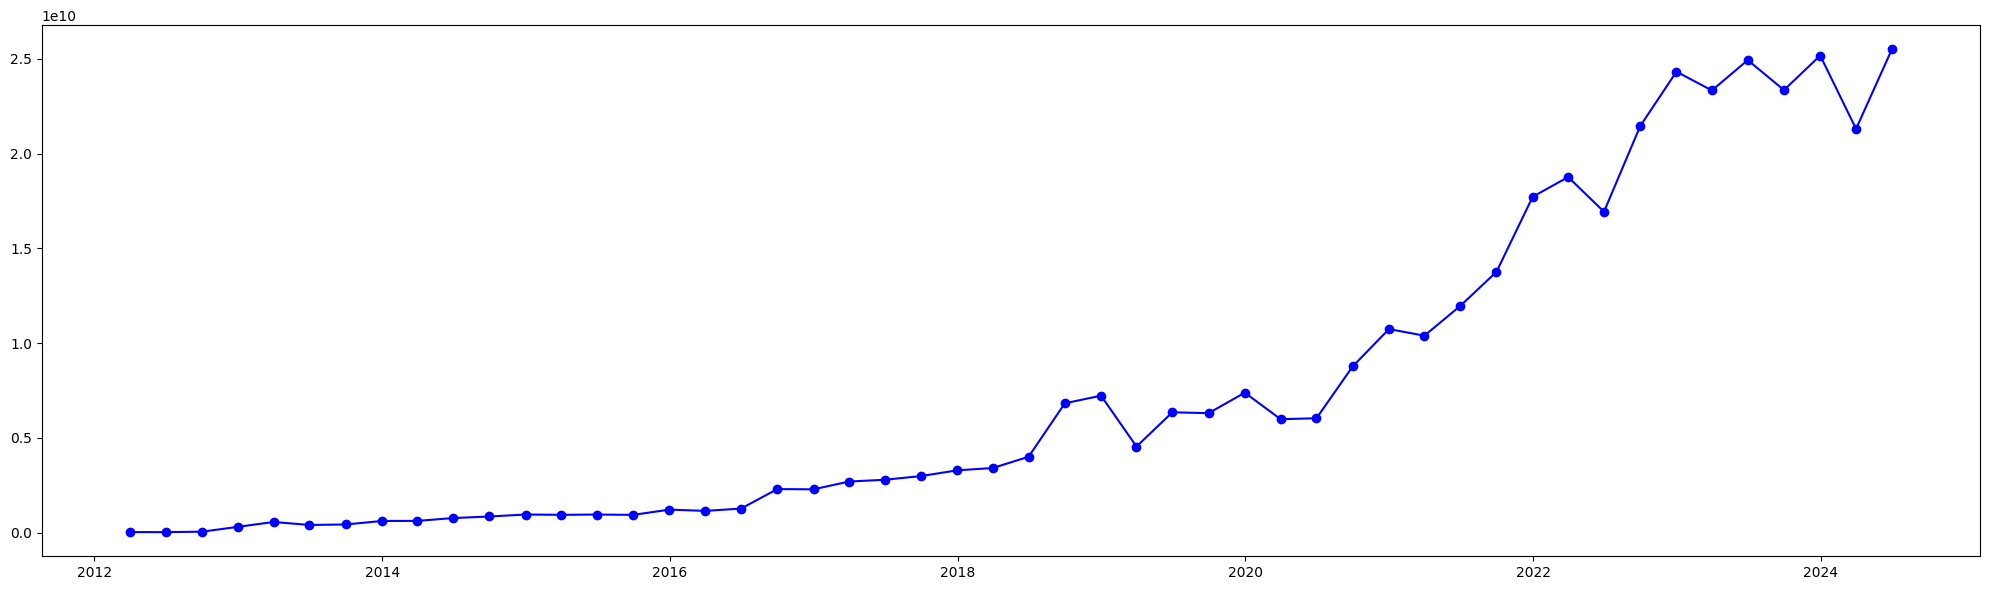

test


In [1]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

url = "https://ycharts.com/companies/TSLA/revenues"

response = requests.get(url, time.sleep(1))

if response.status_code != 200:
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    request = requests.get(url, headers = headers)
    time.sleep(10)
    response = request.text

soup = BeautifulSoup(response,"html.parser")

tables = soup.find_all("table")
tables_with_th = []
tables_body = []

tr = soup.find_all('tr')

# Iterate through each table
for table in tables:
    # Check if there is any <th> element in the table
    if table.find_all('th'):
        tables_with_th.append(table)

counter = 0
for table in tables_with_th:
    if table.find_all("td"):
        tables_body.append(table.find_all("td"))


tesla_revenue = pd.DataFrame(columns = ["Date", "Revenue"])

for table in tables_body:
    Date = ""
    Revenue = ""
    for i, value in enumerate(table):
        if i == 0 or (i % 2 == 0):
            Date = value.text
            #date_list.append(Date)
        else:
            Revenue = str(value.text).replace("\n", "").replace(" ", "")
            if(Revenue[-1] == "B"):
                Revenue = (float(Revenue[:-1]) * 1000000000)
            elif(Revenue[-1] == "M"):
                Revenue = (float(Revenue[:-1]) * 1000000)
            tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({
            "Date": Date,
            "Revenue": Revenue
        }, index = [0])], ignore_index = True)
            
            #if(Revenue[-1] == "B"):
                #revenue_list.append(float(Revenue[:-1]) * 1000000000)
            #elif(Revenue[-1] == "M"):
                #revenue_list.append(float(Revenue[:-1]) * 1000000)
            Date = ""
            Revenue = ""
            

print(tesla_revenue.head())

connection = sqlite3.connect("tesla.db")

connection

cursor = connection.cursor()
cursor.execute("""CREATE TABLE IF NOT EXISTS revenue (Date, Revenue)""")

tesla_tuples = list(tesla_revenue.to_records(index = False))

def is_database_empty():
    # Query to count the number of tables
    cursor.execute("SELECT COUNT(*) FROM sqlite_master WHERE type = 'table'")
    table_count = cursor.fetchone()[0]
    
    return table_count == 0

if is_database_empty():
    cursor.executemany("INSERT INTO revenue VALUES (?,?)", tesla_tuples)
    connection.commit()
else:
    print("database already has data")



for i in range(len(tesla_revenue)):
    tesla_revenue.at[i, 'Date'] = str(datetime.datetime.strptime(tesla_revenue.at[i, "Date"], "%B %d, %Y").date())


#print(tesla_revenue.head())


tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype('int')

#print(tesla_revenue)
plt.figure(figsize=(20, 6))
plt.plot(tesla_revenue['Date'], tesla_revenue['Revenue'], marker='o', linestyle='-', color='b')

#sns.lineplot(data = tesla_revenue, x = "Date", y = "Revenue")

#plt.figure(figsize=(10, 6))
#plt.plot(tesla_revenue['Date'], tesla_revenue['Revenue'], marker='o', linestyle='-', color='b')

plt.tight_layout()

plt.show()
print("test")
